# Recurrent Neural Network

![](https://cdn-images-1.medium.com/max/900/1*2s93v6xvaoGD1ZPRunYPow.png)

![](https://cdn-images-1.medium.com/max/1600/1*uubYiUNDmhmR5KOPdJKYtQ.png)

# Architectures of RNN (popularly used, but not limited) & Applications of RNN

![](http://karpathy.github.io/assets/rnn/diags.jpeg)





## 1.   Character/Word level RNN ([https://github.com/shangeth/Character-Generating-Recurrent-Neural-Network](https://github.com/shangeth/Character-Generating-Recurrent-Neural-Network))
![](http://karpathy.github.io/assets/rnn/charseq.jpeg)

## 2.   Image Captioning
![](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)

## 3.   Sentiment Analysis ([https://github.com/shangeth/NLTK-Twitter-Sentiment-Analysis](https://github.com/shangeth/NLTK-Twitter-Sentiment-Analysis))
![](https://d3ansictanv2wj.cloudfront.net/SentimentAnalysis16-38b6f3cbb7bae622fe0ba114db188666.png)

## 4.   Seq2Seq Machine Translation ( [https://github.com/shangeth/Seq2Seq-Machine-Translation](https://github.com/shangeth/Seq2Seq-Machine-Translation) )
![](https://camo.githubusercontent.com/1fc139938c141a26eb9fdb1b290da2342d632452/68747470733a2f2f736d65726974792e636f6d2f6d656469612f696d616765732f61727469636c65732f323031362f676e6d745f617263685f315f656e635f6465632e737667)














# RNN in Pytorch

## Data

In [2]:
# import torch
# from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

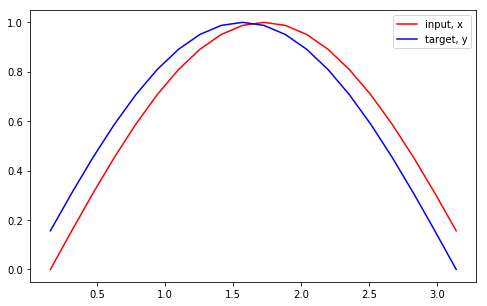

In [0]:
plt.figure(figsize=(8,5))

# how many time steps/data pts are in one batch of data
seq_length = 20

# generate evenly spaced data pts
time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)
data.resize((seq_length + 1, 1)) # size becomes (seq_length+1, 1), adds an input_size dimension

x = data[:-1] # all but the last piece of data
y = data[1:] # all but the first

# display the data
plt.plot(time_steps[1:], x, 'r', label='input, x') # x
plt.plot(time_steps[1:], y, 'b', label='target, y') # y

plt.legend(loc='best')
plt.show()

## Defining Model in Pytorch

Refer the [ PyTorch Documentation](https://pytorch.org/docs/stable/nn.html#rnn)

In [0]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim=hidden_dim
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)  
        
        # get final output 
        output = self.fc(r_out)
        
        return output, hidden

### Test the model

In [0]:
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=2)

y, hidden = test_rnn(torch.randn(1, 20, 1), None)
hidden

tensor([[[ 0.2497, -0.1435, -0.1475, -0.2484,  0.1589, -0.3102,  0.2622,
          -0.0126,  0.1641, -0.3862]],

        [[ 0.2411, -0.0629, -0.6140,  0.2090, -0.1260,  0.1139, -0.0058,
           0.3674,  0.3698, -0.2244]]], grad_fn=<StackBackward>)

## Loss and Optimizer

In [0]:
rnn = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=2)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=1e-3)

## Training Loop

In [0]:
def train(rnn, n_steps, print_every):
    
    # initialize the hidden state
    hidden = None      
    
    for batch_i, step in enumerate(range(n_steps)):
        
        # defining the training data
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = 2*np.sin(time_steps) - np.pi *np.cos(time_steps) 
        data.resize((seq_length + 1, 1)) # input_size=1

        x = data[:-1]
        y = data[1:]
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)
        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)
#         print(prediction)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(time_steps[1:], y, 'r') # input
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b') # predictions
            plt.show()
    
    return rnn

## Train

Loss:  0.9581961631774902


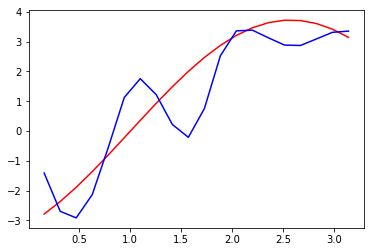

Loss:  0.1370832473039627


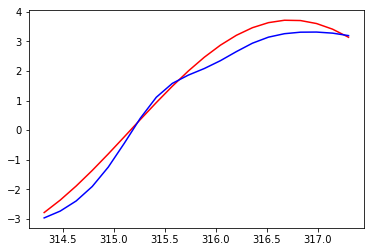

Loss:  0.10702160000801086


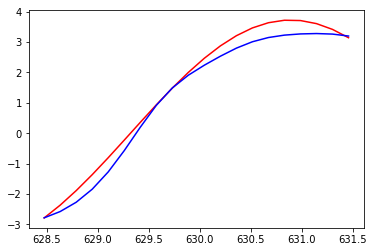

Loss:  0.08608820289373398


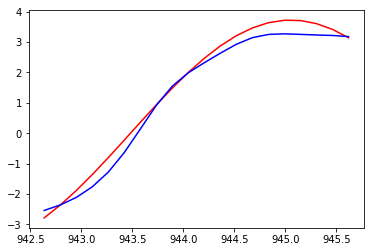

Loss:  0.10726811736822128


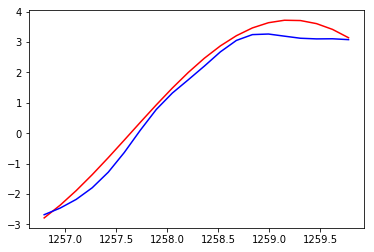

Loss:  0.08752484619617462


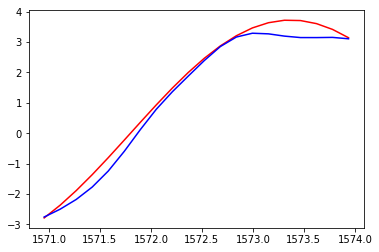

Loss:  2.1886818408966064


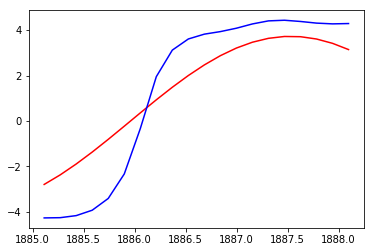

Loss:  0.14279800653457642


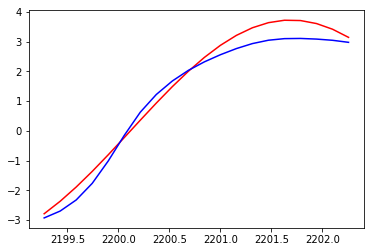

Loss:  0.11391783505678177


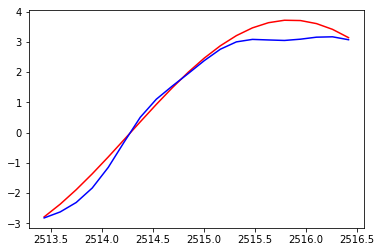

Loss:  0.06465962529182434


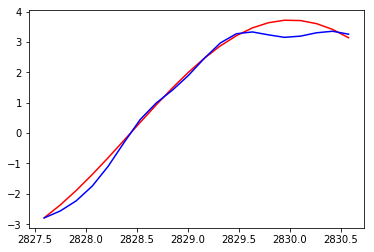

Loss:  0.052558548748493195


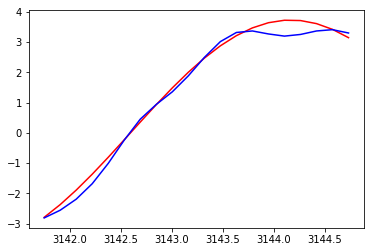

Loss:  0.046624958515167236


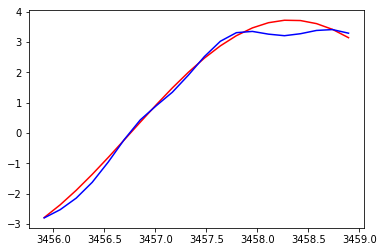

Loss:  0.04200775921344757


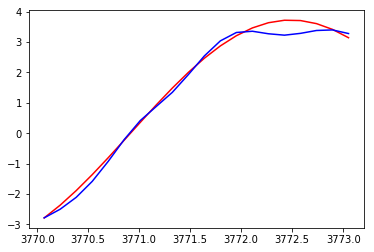

Loss:  0.31421661376953125


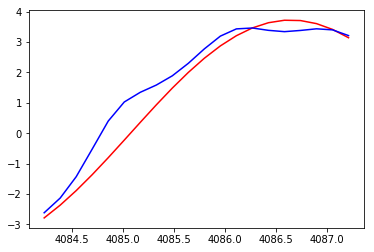

Loss:  0.03208156302571297


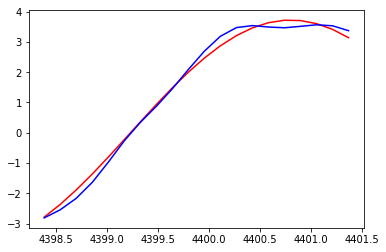

In [0]:
n_steps = 1500
print_every = 100

trained_rnn = train(rnn, n_steps, print_every)